<a href="https://colab.research.google.com/github/pi4imu/work-in-iki/blob/master/exploring_emcee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import minimize

In [2]:
! pip install emcee
! pip install corner

import emcee
import corner


     |████████████████████████████████| 51kB 2.6MB/s 


# Данные

Подгрузим все данные.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/IKI/Микролинзирование/

#lensPlane1=fits.open("maps/IRIS417.fits")[0].data
#lensPlane2=fits.open("maps/IRIS314.fits")[0].data

Mounted at /content/drive
/content/drive/My Drive/IKI/Микролинзирование


Незашумленные кривые блеска:

In [4]:
filename = 'data/refE5R50M20Ni2m2b5m3Z01_h5.ubv' 
model_curves = pd.read_csv(filename, header=0, delim_whitespace=True)

t1 = np.array(model_curves.time.values)      
lc1 = np.array(model_curves.F160W.values)

t_min = 20
cadence = 98 #test

t1_grid = np.linspace(t_min, np.max(t1), cadence) # зададим сетку, чтобы точно контролировать количество точек и временной интервал
m1 = np.interp(t1_grid, t1, lc1)  # линейная интерполяция кривой lc1 на новую сетку t1_grid

Сдвинем кривую по времени и магнитуде:

In [53]:
dt_true = 9.5            

magn_ratio = 1.14

dm_true = -2.5*np.log10(magn_ratio)
print(dm_true)

t2_grid = t1_grid + dt_true # второе изображение
m2 = m1 + dm_true

-0.14226212834118138


Функция для единого оформления графиков:

In [54]:
from matplotlib import rcParams

def grafik():
  
  rcParams['figure.figsize'] = (7,5)
  plt.title('Кривые блеска SN Refsdal', fontsize=15)
  plt.xlabel('Время (в днях) с момента взрыва сверхновой', fontsize=15)
  plt.ylabel('Блеск', fontsize=15)
  #plt.ylim(28.5, 26)
  plt.gca().invert_yaxis()
  plt.legend()
  plt.grid()
  plt.show()

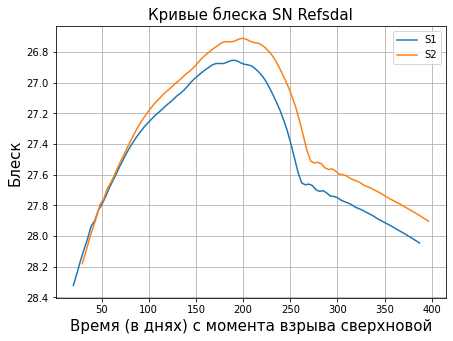

In [55]:
plt.plot(t1_grid, m1, label="S1")
plt.plot(t2_grid, m2, label="S2")

grafik()

# Добавляем микролинзирование

Добавим шум:

In [56]:
fluct1 = pd.read_csv('data/micro_data_S1_new.csv').to_numpy()
fluct2 = pd.read_csv('data/micro_data_S2_new.csv').to_numpy()
length=98

In [11]:
pd.DataFrame(fluct1).drop([i for i in range(5,3+length-2)], axis=1).drop([i for i in range(3+length+2,3+2*length-2)], axis=1).drop([i for i in range(3+2*length+2,3+3*length-2)], axis=1)

,0,1,2,3,4,99,100,101,102,197,198,199,200,295,296
0,403.0,125.0,98.0,0.0,1.0,96.0,97.0,1.077474,1.070596,1.051873,1.051273,1.077474,1.070507,0.870023,0.859940
1,384.0,826.0,98.0,0.0,1.0,96.0,97.0,0.561010,0.568459,0.320923,0.318220,0.561010,0.568501,0.213811,0.217079
2,463.0,863.0,98.0,0.0,1.0,96.0,97.0,0.979463,0.975701,0.908491,0.906971,0.979463,0.975754,0.581178,0.568260
3,893.0,184.0,98.0,0.0,1.0,96.0,97.0,1.002474,0.993648,0.970901,0.970424,1.002474,0.993466,0.864534,0.858241
4,261.0,760.0,98.0,0.0,1.0,96.0,97.0,0.654035,0.648156,0.656453,0.657364,0.654035,0.648132,0.591937,0.584772
5,302.0,621.0,98.0,0.0,1.0,96.0,97.0,0.116976,0.115318,-0.097342,-0.099078,0.116976,0.115242,-0.156273,-0.152001
6,724.0,225.0,98.0,0.0,1.0,96.0,97.0,0.852675,0.856176,0.633940,0.630173,0.852675,0.856246,0.374486,0.374624
7,405.0,417.0,98.0,0.0,1.0,96.0,97.0,0.834010,0.838266,0.706656,0.703528,0.834010,0.838343,0.335514,0.332297
8,108.0,819.0,98.0,0.0,1.0,96.0,97.0,1.016961,1.016834,0.985836,0.985510,1.016961,1.016704,0.937048,0.935758
9,523.0,262.0,98.0,0.0,1.0,96.0,97.0,0.728922,0.733400,0.256178,0.257483,0.728922,0.733392,0.502950,0.505802


In [12]:
pd.DataFrame(fluct2).drop([i for i in range(5,3+length-2)], axis=1).drop([i for i in range(3+length+2,3+2*length-2)], axis=1).drop([i for i in range(3+2*length+2,3+3*length-2)], axis=1)

,0,1,2,3,4,99,100,101,102,197,198,199,200,295,296
0,848.0,576.0,98.0,0.0,1.0,96.0,97.0,0.081399,0.064685,-0.354624,-0.355956,0.081399,0.064459,-0.401809,-0.401279
1,241.0,332.0,98.0,0.0,1.0,96.0,97.0,0.297649,0.281200,-0.078989,-0.078349,0.297649,0.280786,0.051069,0.053992
2,430.0,330.0,98.0,0.0,1.0,96.0,97.0,1.163613,1.031220,0.314809,0.310953,1.163613,1.028173,-0.012292,-0.012002
3,231.0,489.0,98.0,0.0,1.0,96.0,97.0,-0.676070,-0.686229,-0.147864,-0.145801,-0.676070,-0.686425,-0.047924,-0.049187
4,446.0,445.0,98.0,0.0,1.0,96.0,97.0,1.272564,1.295591,0.682830,0.673846,1.272564,1.296008,-0.109605,-0.108590
5,759.0,272.0,98.0,0.0,1.0,96.0,97.0,0.538637,0.541549,0.092408,0.091207,0.538637,0.541688,-0.041011,-0.044115
6,599.0,699.0,98.0,0.0,1.0,96.0,97.0,1.183726,1.200514,0.405214,0.400092,1.183726,1.200327,0.039705,0.030898
7,524.0,892.0,98.0,0.0,1.0,96.0,97.0,0.052403,0.017054,0.153402,0.152995,0.052403,0.017953,0.031729,0.027527
8,746.0,652.0,98.0,0.0,1.0,96.0,97.0,-0.981884,-0.977017,-0.553812,-0.552509,-0.981884,-0.976033,-0.311301,-0.308775
9,526.0,784.0,98.0,0.0,1.0,96.0,97.0,1.097089,1.088352,-0.257901,-0.256943,1.097089,1.088463,-0.094831,-0.092169


In [13]:
xxs = (fluct1[:, 0], fluct2[:, 0])
yys = (fluct1[:, 1], fluct2[:, 1])
lengths = (fluct1[:,2].astype(int), fluct2[:,2].astype(int))
time_grids = (fluct1[:, 3:3+length], fluct2[:, 3:3+length])
dm_gausss = (fluct1[:, 3+length:3+2*length], fluct2[:, 3+length:3+2*length])
dm_flats = (fluct1[:, 3+2*length:3+3*length], fluct2[:, 3+2*length:3+3*length])

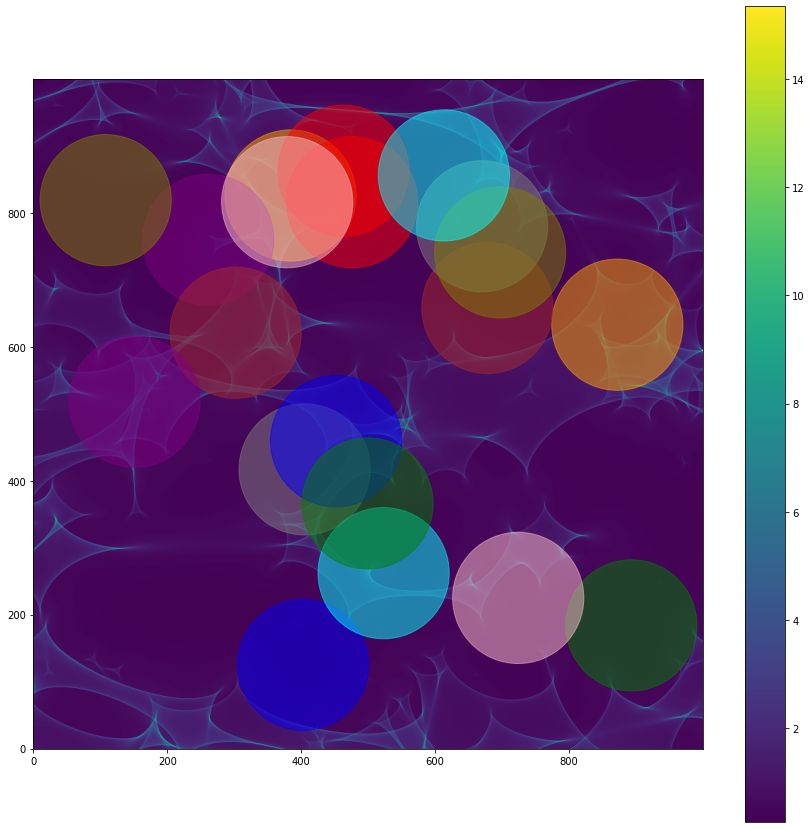

In [23]:
colors = 2*('blue', 'orange', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive','cyan')

#417 - s1
#314 - s2

map_number = 417
s=1

image_data = fits.getdata("maps/IRIS"+str(map_number)+".fits")
image = 10**(.4*(image_data-1024)/256.0)

plt.figure(figsize=(15,15))
plt.imshow(image, origin='lower')
plt.colorbar()

for j in range(0, len(fluct2)):

  xx = xxs[s-1][j]
  yy = yys[s-1][j]
  length = lengths[s-1][j]
  time_grid = time_grids[s-1][j]
  dm_gauss = dm_gausss[s-1][j]
  dm_flat = dm_flats[s-1][j]
 
  plt.gca().add_patch( plt.Circle((xx,yy), length, color=colors[j], alpha=0.5) )

plt.savefig('map_with_circles_S2.png')
plt.show()

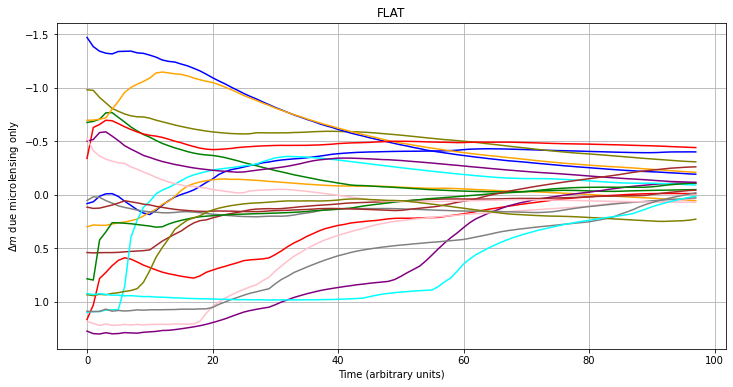

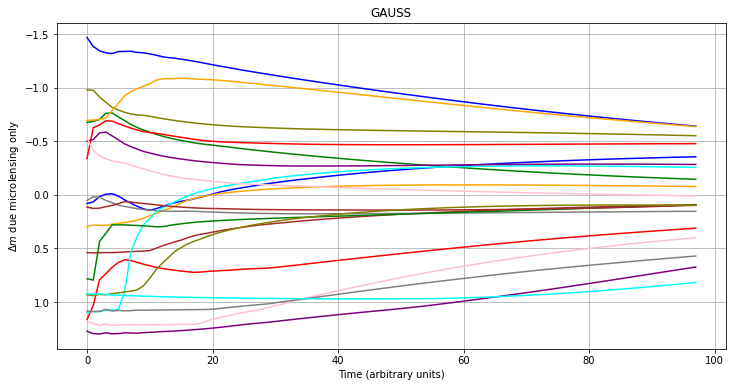

In [24]:
s=2

plt.figure(figsize=(12,6))

for j in range(0, len(fluct2)):

  time_grid = time_grids[s-1][j]
  dm_gauss = dm_gausss[s-1][j]
  dm_flat = dm_flats[s-1][j]
  
  #print('Number', j, ', center = (', xx, ',', yy,')')
  
  #plt.plot(time_grid, dm_gauss, label='gauss')
  plt.plot(time_grid, dm_flat, label='flat', color=colors[j])
  #plt.axhline(np.median(dm_gauss), color='r', linestyle='--', label='gauss mean')
  #plt.axhline(np.median(dm_flat), color='g', linestyle='--', label='flat mean')
plt.gca().invert_yaxis()
plt.xlabel('Time (arbitrary units)')
plt.ylabel('$\Delta m$ due microlensing only')
plt.title('FLAT')
#plt.legend()
plt.grid()
plt.savefig('S'+str(s)+'_flat.png')
plt.show()

plt.figure(figsize=(12,6))

for j in range(0, len(fluct2)):

  time_grid = time_grids[s-1][j]
  dm_gauss = dm_gausss[s-1][j]
  dm_flat = dm_flats[s-1][j]
   
  plt.plot(time_grid, dm_gauss, label='gauss', color=colors[j])
  
plt.title('GAUSS')
plt.gca().invert_yaxis()
plt.xlabel('Time (arbitrary units)')
plt.ylabel('$\Delta m$ due microlensing only')
#plt.legend()
plt.grid()
plt.savefig('S'+str(s)+'_gauss.png')
plt.show()

In [57]:
#microlensing_noise1 = -2.5*np.log10(dm_gauss[8]) #np.random.normal(0., 0.1, len(t1_grid)) 
#microlensing_noise2 = -2.5*np.log10(dm_gauss[5]) #np.random.normal(0., 0.1, len(t2_grid))

lc1_noise = m1 + dm_flats[0][7]# microlensing_noise1
lc2_noise = m2 + dm_flats[1][6]#microlensing_noise2

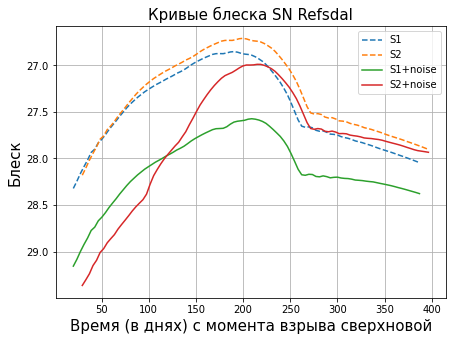

In [58]:
plt.plot(t1_grid, m1, linestyle='--', label="S1")
plt.plot(t2_grid, m2, linestyle='--', label="S2")

plt.plot(t1_grid, lc1_noise, label="S1+noise")
plt.plot(t2_grid, lc2_noise, label="S2+noise")

#lc2_noise_shifted = np.interp(t1_grid + dt_true, t2_grid, lc2_noise) - dm_true
#plt.plot(t1_grid, lc2_noise_shifted, label="S2 shifted")

grafik()

# emcee

Зададим необходимые функции. Логика следующая: мы "кормим" алгоритм данными из изображения S2, а потом сдвигаем их по времени и магнитуде и сравниваем с изображением S1.

In [27]:
def model(params, x1, x2, y2):
    dt, dmu = params
    #func = interpolate.interp1d(x2, y2)
    #return func(x1 + dt) - dmu
    return np.interp(x1 + dt, x2, y2) - dmu

def lnlike(params, x1, y1, x2, y2):
    dt, dmu = params
    lnlike = -0.5 * np.sum( ( (y1 - model(params, x1, x2, y2))/1 )**2 )# + np.log(2*np.pi*sigmu**2) )
    return lnlike

def lnprior(params):
    dt, dmu = params
    if (0. < dt < 100. and -5. < dmu < 5. ):
        return 0.0
    return -np.inf

def lnprob(params, x1, y1, x2, y2):
    lp = lnprior(params)
    if np.isfinite(lp):
      return lp + lnlike(params, x1, y1, x2, y2)
    else:
      return -np.inf

In [28]:
def best_with_MCMC(dtTrue, dmTrue, lengthofchain, arguments, draw):

  #np.random.seed(45)
  #lnlike1 = lambda *args: -lnlike(*args)
  #initial = np.array([dtTrue, dmTrue]) + 0.01 * np.random.randn(2)
  #optim = minimize(lnlike1, initial, args=arguments)
  
  nwalkers = 100
  initial = [dtTrue, dmTrue]
  ndim = len(initial)
  p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim) for i in range(nwalkers)]
  sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = arguments )
  #p0, _, _ = sampler.run_mcmc(p0, 500, progress=True)
  #sampler.reset()
  sampler.run_mcmc(p0, lengthofchain, progress = True)

  samples = sampler.flatchain
  s  = samples[np.argmax(sampler.flatlnprobability)]

  #print("Initial dt = {0:.3f}".format(initial[0]))
  #print("Initial dm = {0:.3f}".format(initial[1]))
  #print("sigmu = {0:.3f}".format(optim.x[2]))

  #print('Best dt = {0:.3f}'.format(s[0]))
  #print('Best dmu = {0:.3f}'.format(s[1])) 
  #print('or best magnification ratio = {0:.3f}'.format(10**(-0.4*s[1])) )

  if draw:
        
    plt.plot(arguments[0], arguments[1], label='S1')
    plt.plot(arguments[2], arguments[3], label='S2')
    #if show_all:
    #  for s in samples[np.random.randint(len(samples), size=50)]:
    #    plt.plot(arguments[0], model(s, arguments[0], arguments[2], arguments[3]), color="r", alpha=0.1)
    #else:
    best_fit_model = model(s, arguments[0], arguments[2], arguments[3])
    plt.plot(arguments[0], best_fit_model, color="r", label='Best fit')
    grafik()

    if False:
      fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
      chain = sampler.get_chain()
      labels = ['$\Delta t$', '$\Delta m$', '$\sigma_m$']
      for i in range(ndim):
          ax = axes[i]
          ax.plot(chain[:, :, i], "k", alpha=0.3)
          ax.set_xlim(0, len(chain))
          ax.set_ylabel(labels[i])
          ax.yaxis.set_label_coords(-0.1, 0.5)
      axes[-1].set_xlabel("step number")
      #tau = sampler.get_autocorr_time()
      #print(tau)
      #flat_samples = sampler.get_chain()#discard=400, thin=1, flat=False)
      #print(flat_samples.shape)
    
      fig = corner.corner(sampler.flatchain, 
                          show_titles=True, 
                          labels=['$\Delta t$', '$\Delta m$'], 
                          truths=[dt_true, dm_true], 
                          scale_hist=True, 
                          quantiles=[0.16, 0.5, 0.84])

  return s[0], s[1]

In [29]:
#best_dt, best_dm = best_with_MCMC(dtTrue=dt_true, 
#                                  dmTrue=dm_true, 
#                                  lengthofchain=1000, 
#                                  arguments=(t1_grid, lc1_noise, t2_grid, lc2_noise), 
#                                  draw=False)

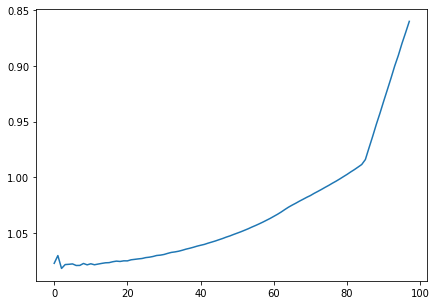

In [59]:
dm_flat1 = dm_flats[0][0]
dm_gauss1 = dm_gausss[0][0]
time_grid1 = time_grids[0][0]


plt.plot(time_grid1, dm_flat1)
plt.gca().invert_yaxis()

In [60]:
best_dt = []
best_dm = []

for i in range(0, len(fluct1)):
  for j in range(0, len(fluct2)):

    dm_flat1 = dm_flats[0][i]
    dm_flat2 = dm_flats[1][j]

    dm_gauss1 = dm_gausss[0][i]
    dm_gauss2 = dm_gausss[1][j]

    #МЕНЯТЬ ЗДЕСЬ
#----------------------------
    microlensing_noise1 = dm_flat1
    microlensing_noise2 = dm_flat2
#----------------------------
    lc1_noise = m1 + microlensing_noise1
    lc2_noise = m2 + microlensing_noise2

    best_dt1, best_dm1 = best_with_MCMC(dtTrue=dt_true, 
                                    dmTrue=dm_true, 
                                    lengthofchain=1000, 
                                    arguments=(t1_grid, lc1_noise, t2_grid, lc2_noise), 
                                    draw = False)
  
    best_dt.append(best_dt1)
    best_dm.append(best_dm1)

100%|██████████| 1000/1000 [00:03<00:00, 254.93it/s]


True dt = 9.50
True dm = -0.14
FLAT:


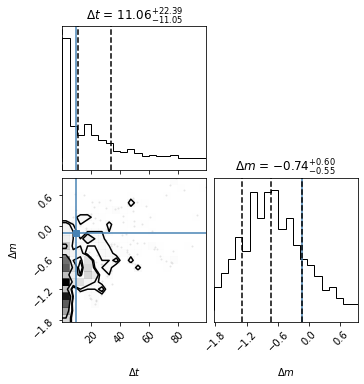

In [62]:
print("True dt = {0:.2f}".format(dt_true))
print("True dm = {0:.2f}".format(dm_true))
print("FLAT:")

fig = corner.corner(np.transpose([best_dt, best_dm]), 
                    show_titles=True, 
                    range=(1.,1.),
                    labels=['$\Delta t$', '$\Delta m$'], 
                    truths=[dt_true, dm_true], 
                    scale_hist=True, 
                    quantiles=[0.16, 0.5, 0.84])

In [52]:
pd.DataFrame([best_dt, best_dm]).to_csv('data/delays-2-flat.csv', index=False)